# NY Fed Financial Conditions

## Packages

In [54]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import statsmodels.api as sm
import pandas_datareader as web

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## Read Data

In [2]:
df = pd.read_parquet(
    path = "financial_conditions_prep.parquet",
    engine = "pyarrow")

## EDA Plotting

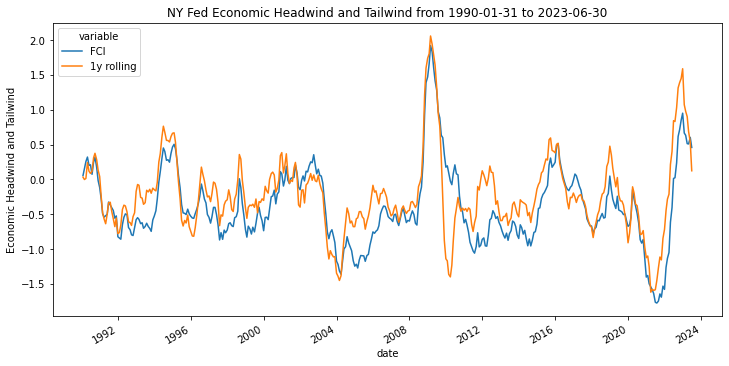

In [3]:
(df.set_index(
    "date").
    rename(columns = {
        "fci_baseline": "FCI",
        "fci_rolling_year": "1y rolling"}).
    plot(
        figsize = (12, 6),
        ylabel = "Economic Headwind and Tailwind",
        title = "NY Fed Economic Headwind and Tailwind from {} to {}".format(
            df.date.min().date(), df.date.max().date())))

plt.show()

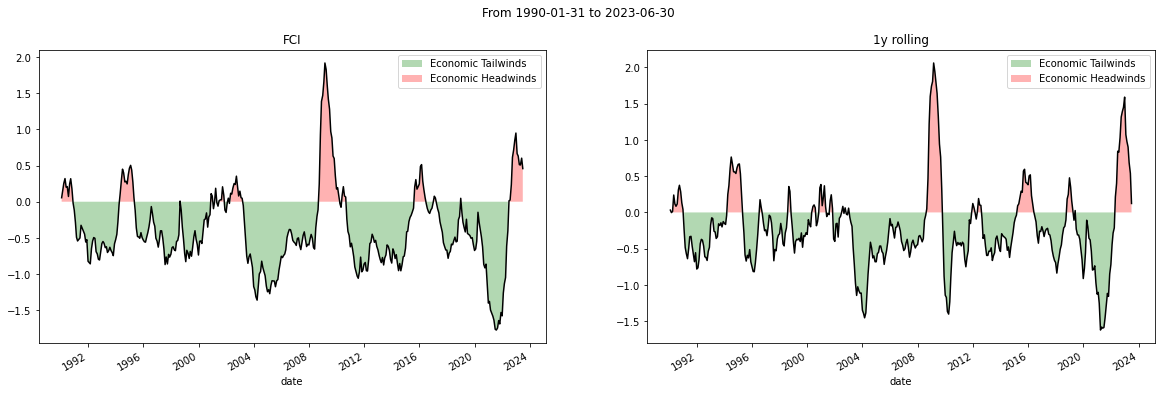

In [4]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))

(df.set_index(
    "date").
    rename(columns = {
        "fci_baseline": "FCI"})
    [["FCI"]].
    plot(
        ax = axes[0],
        color = "black",
        legend = False,
        title = "FCI"))

(df.set_index(
    "date").
    rename(columns = {
        "fci_rolling_year": "1y rolling"})
    [["1y rolling"]].
    plot(
        ax = axes[1],
        color = "black",
        title = "1y rolling",
        legend = False))

axes[0].fill_between(
    x = df.date,
    y1 = df["fci_baseline"].values,
    y2 = 0,
    where = df["fci_baseline"].values > 0,
    facecolor = "red",
    alpha = 0.3)

axes[0].fill_between(
    x = df.date,
    y1 = df["fci_baseline"].values,
    y2 = 0,
    where = df["fci_baseline"].values < 0,
    facecolor = "green",
    alpha = 0.3)

axes[1].fill_between(
    x = df.date,
    y1 = df["fci_rolling_year"].values,
    y2 = 0,
    where = df["fci_rolling_year"].values > 0,
    facecolor = "red",
    alpha = 0.3)

axes[1].fill_between(
    x = df.date,
    y1 = df["fci_rolling_year"].values,
    y2 = 0,
    where = df["fci_rolling_year"].values < 0,
    facecolor = "green",
    alpha = 0.3)

legend_elements = [
    Patch(facecolor = "green", alpha = 0.3, label = "Economic Tailwinds"),
    Patch(facecolor = "red", alpha = 0.3, label = "Economic Headwinds")]

axes[0].legend(handles = legend_elements)
axes[1].legend(handles = legend_elements)

fig.suptitle("From {} to {}".format(
    df.date.min().date(),
    df.date.max().date()))

plt.show()

## Examining in comparison to various asset classes

In this case we'll use a series of asset classes as well breakdowns within that asset class in comparison to this model
1. Equities: S&P 500, Russell 1000, Rusell 2000, Russell 3000, NASDAQ, Value Equities (VTV), Growth Equities (VUG)
2. Fixed Income: Treasuires (TLT), Investment Grade (AGG), High Yield (HYG)
3. Commodities: Gold (GLD), OIL (USO)
4. FX: US dollar index (DXY), 3m Treasury Bill (DGS3MO), 10y TIPS (DFII10)

We will also set up these regressions as Financial Conditions vs. 1m lag of the security to see if it can forecast. I will use the results to make future determinations and at this junction it should be noted that I am artificially overfitting the model by running the regression and then fitting the data on the same model. I've made this deliberate choice because I'd like to analyze all of the information and the data comes in monthly from 1992. I am also interested in the performance of the models during periods of stress such as 2008 and 2020. To avoid as much overfitting as I've artificially injected I'll keep my model as robust and less-complex as possible.

Get statistics ready for data collection

In [10]:
try:
    
    df_yf = pd.read_parquet(
        path = "yf_asset_data.parquet",
        engine = "pyarrow")
    
    df_fred = pd.read_parquet(
        path = "fred_tsy.parquet",
        engine = "pyarrow")
    
except:

    start_date, end_date = df.date.min().date(), df.date.max().date()
    equity_tickers = ["SPY", "IWB", "IWM", "IWV", "QQQ", "VTV", "VUG"]
    fixed_income_tickers = ["TLT", "AGG", "HYG"]
    commodities_tickers = ["GLD", "USO"]
    fx_tickers = ["DXY"]
    fred_tickers = ["DGS3MO", "DFII10"]

    yf_combined_tickers = equity_tickers + fixed_income_tickers + commodities_tickers + fx_tickers

    df_yf = (yf.download(
        tickers = yf_combined_tickers,
        start = start_date,
        end = end_date).
        reset_index().
        melt(id_vars = "Date"))

    df_yf.to_parquet(
        path = "yf_asset_data.parquet",
        engine = "pyarrow")

    df_fred = (web.DataReader(
        name = fred_tickers,
        data_source = "fred",
        start = start_date,
        end = end_date))

    df_fred.to_parquet(
        path = "fred_tsy.parquet",
        engine = "pyarrow")

[*********************100%***********************]  13 of 13 completed


Clean and combine data

In [21]:
df_yf_prep = (df_yf.query(
    "variable_0 == 'Adj Close'").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    dropna())

df_fred_prep = (df_fred.reset_index().rename(
    columns = {"DATE": "Date"}).
    melt(id_vars = "Date").
    dropna().
    rename(columns = {"variable": "ticker"}))

df_combined = pd.concat([df_yf_prep, df_fred_prep])

Get the data into monthly format

In [36]:
def _monthly_resample(df: pd.DataFrame) -> pd.DataFrame:
    return(df.set_index("Date").resample("M").last())

df_combined_monthly = (df_combined.groupby(
    "ticker").
    apply(_monthly_resample).
    drop(columns = ["ticker"]).
    reset_index().
    rename(columns = {"Date": "date"}))

Just make sure it merges before we take percent change

In [37]:
(df.merge(
    df_combined_monthly, how = "inner", on = ["date"]))

,date,fci_baseline,fci_rolling_year,ticker,value
0,1990-01-31,0.055045,0.031725,DGS3MO,8.000000
1,1990-02-28,0.152626,-0.002490,DGS3MO,8.040000
2,1990-04-30,0.320139,0.239715,DGS3MO,8.070000
3,1990-05-31,0.199919,0.116545,DGS3MO,8.010000
4,1990-07-31,0.072394,0.116790,DGS3MO,7.740000
...,...,...,...,...,...
2749,2023-06-30,0.458444,0.123203,SPY,438.109985
2750,2023-06-30,0.458444,0.123203,TLT,101.186348
2751,2023-06-30,0.458444,0.123203,USO,62.959999
2752,2023-06-30,0.458444,0.123203,VTV,140.899994


Now take percent change and shift and then remerge

In [48]:
df_monthly_rtn = (df_combined_monthly.pivot(
    index = "date", columns = "ticker", values = "value").
    pct_change().
    shift(1).
    reset_index().
    melt(id_vars = "date").
    dropna())

In [49]:
df_monthly_rtn

,date,ticker,value
166,2003-11-30,AGG,-0.009347
167,2003-12-31,AGG,0.003344
168,2004-01-31,AGG,0.009793
169,2004-02-29,AGG,0.004404
170,2004-03-31,AGG,0.011415
...,...,...,...
6025,2023-02-28,VUG,0.103843
6026,2023-03-31,VUG,-0.014241
6027,2023-04-30,VUG,0.077621
6028,2023-05-31,VUG,0.010383


In [57]:
df_fi_combined = (df.melt(
    id_vars = "date").
    rename(columns = {
        "variable": "fi_index",
        "value": "fi_value"}).
    merge(df_monthly_rtn, how = "inner", on = ["date"]).
    rename(columns = {"value": "rtn"}))

C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
C:\Users\Diego\AppData\Local\Temp/ipykernel_6744/2186887051.py:25: RuntimeWarning: invalid value encountered in add
  y = (beta * x) + alpha
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1697: RuntimeWarning: invalid value encountered in subtract
  return self.model.wendog - self.model.predict(
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
C:\Users\Diego\AppData\Local\Temp/ipykernel_6744/2186887051.py:25: RuntimeWarning: invalid value encountered in add
  y = (beta * x) + alpha
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1697: RuntimeWarning: invalid value encountered in subtract

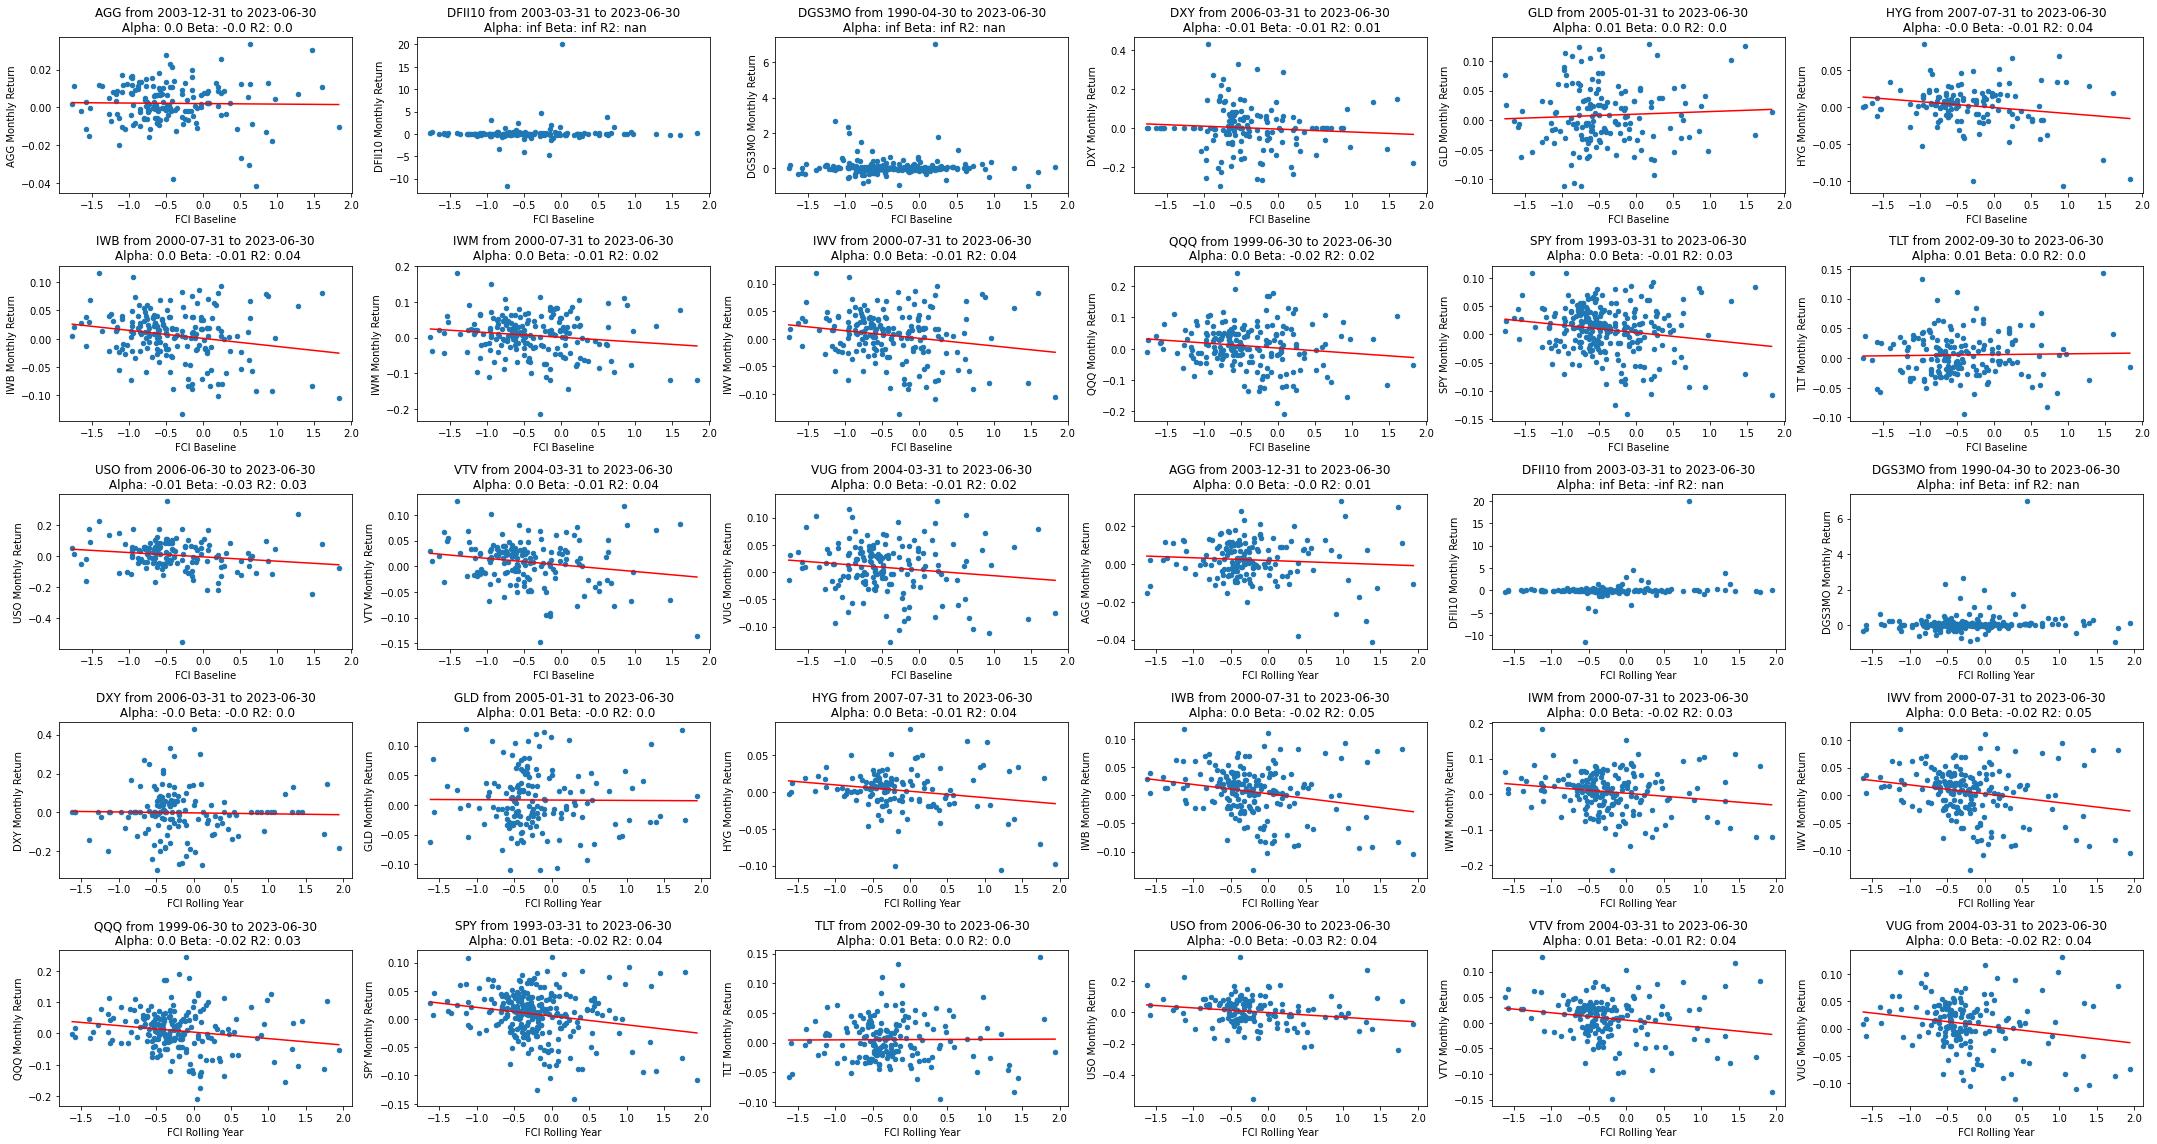

In [91]:
df_fi_combined_grouped = df_fi_combined.groupby(["fi_index", "ticker"])
fig, axes = plt.subplots(ncols = 6, nrows = 5, figsize = (30, 16))

i, j = 0, 0
for group in df_fi_combined_grouped:
    
    if group[1].fi_index.iloc[0] == "fci_baseline":
        col_name = "FCI Baseline"
        
    else: col_name = "FCI Rolling Year"
    
    regression = (sm.OLS(
        endog = group[1].rtn,
        exog = sm.add_constant(group[1].fi_value)).
        fit())
    
    alpha, beta = regression.params
    rsquared = regression.rsquared
    
    x = np.linspace(
        start = group[1].fi_value.min(),
        stop = group[1].fi_value.max(),
        num = 1_000)
    
    y = (beta * x) + alpha
    
    (group[
        1].
        plot(
            kind = "scatter",
            x = "fi_value", y = "rtn",
            ax = axes[i,j],
            xlabel = col_name,
            ylabel = "{} Monthly Return".format(
                group[1].ticker.iloc[0]),
            title = "{} from {} to {}\n Alpha: {} Beta: {} R2: {}".format(
                group[1].ticker.iloc[0],
                group[1].date.min().date(),
                group[1].date.max().date(),
                round(alpha, 2),
                round(beta, 2),
                round(rsquared, 2))))
    
    axes[i,j].plot(x, y, color = "red")
    
    if j == 5:
        i += 1
        j = 0
        
    else: 
        j += 1

    
plt.tight_layout()

Need to add a dataframe that appends the results from the regression and then analyze it from there